In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

import warnings
warnings.filterwarnings("ignore")



### Checking to see what features are in the csv

In [2]:

df = pd.read_csv('cleaned_pfas_cancer_merged.csv')
print(df.head())
print("\nAvailable Features:")
print(df.columns.tolist())
print("\nMissing values per column:")
print(df.isna().sum())


    county gm_samp_collection_date   10:2FTS  11ClPF3OUDS   3:3FTCA    4:2FTS  \
0  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
1  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
2  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
3  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   
4  Alameda              2018-09-11  1.200595     1.120463  1.658471  2.179993   

    5:3FTCA    6:2FTS   7:3FTCA    8:2FTS  ...     PFPES    PFTEDA   PFTRIDA  \
0  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
1  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
2  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
3  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   
4  1.485784  7.667568  1.847953  4.009532  ...  4.951307  1.458615  1.458615   

    PFUNDCA  total_pfas_concentr

In [4]:

numeric_df = df.select_dtypes(include='number')
correlations = numeric_df.corr()['AAIR'].dropna()
exclude = ['total_pfas_concentration', 'PopTot', 'Cancer_Incidents', 'AAIR']
chemical_correlations = correlations.drop(labels=exclude, errors='ignore')
top_10_chemicals = chemical_correlations.abs().sort_values(ascending=False).head(10)

print("Top 10 PFAS chemicals correlated with AAIR:")
print(top_10_chemicals)


Top 10 PFAS chemicals correlated with AAIR:
ETFOSE      0.027860
MEFOSE      0.025227
PFHXDA      0.019045
ETFOSA      0.014508
MEFOSA      0.012733
PFUNDCA     0.012703
PFDOA       0.011038
PFNS        0.010826
NMEFOSAA    0.010358
NETFOSAA    0.010175
Name: AAIR, dtype: float64


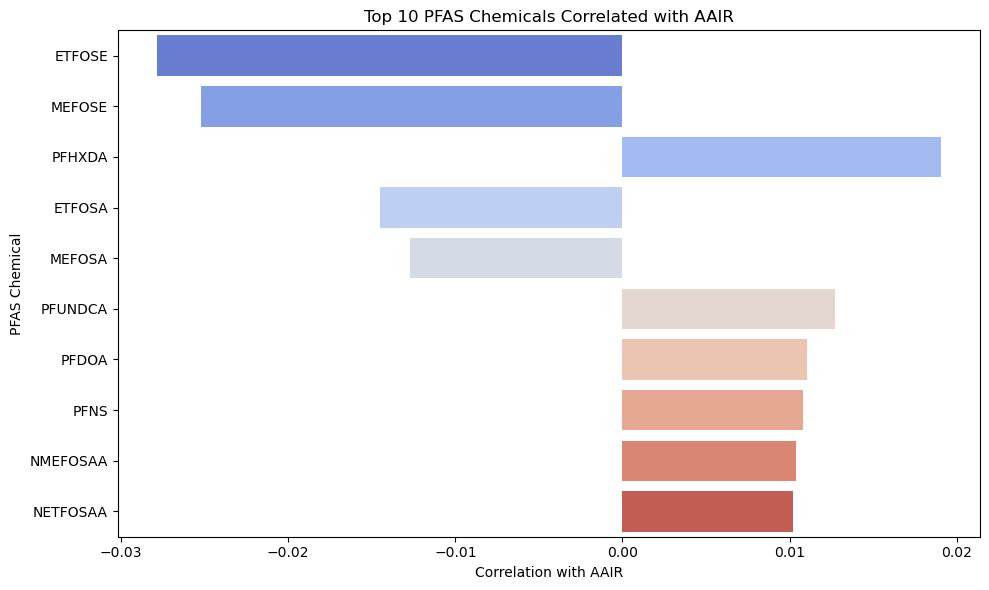

In [5]:

# Sort the top 10 chemicals with actual (signed) correlations
top_10_corr = chemical_correlations.loc[top_10_chemicals.index]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index, palette='coolwarm')
plt.title("Top 10 PFAS Chemicals Correlated with AAIR")
plt.xlabel("Correlation with AAIR")
plt.ylabel("PFAS Chemical")
plt.tight_layout()
plt.show()


### Extracting the top 10 Chemicals


In [9]:

top_10_chemicals_list = top_10_corr.index.tolist()

non_chemical_columns = [
    'county',
    'gm_samp_collection_date',
    'total_pfas_concentration',
    'Cancer_Incidents',
    'AAIR',
    'PopTot',
    'Sex',
    'Cancer'
]

reduced_df = df[top_10_chemicals_list + non_chemical_columns]

 ### One-Hot Encoding + Binary Label Creation + Data Preparation

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

encoded_df = pd.get_dummies(reduced_df, columns=['Sex', 'Cancer'], drop_first=True)

# Create AAIR binary label
mean_aair = encoded_df['AAIR'].mean()
encoded_df['AAIR_Label'] = (encoded_df['AAIR'] > mean_aair).astype(int)

# Save the encoded dataframe with all features
encoded_df.to_csv("reduced_pfas_dataset.csv", index=False)

# Prepare features and labels for ML
features_to_drop = ['AAIR', 'Cancer_Incidents', 'gm_samp_collection_date', 'county']
X = encoded_df.drop(columns=features_to_drop + ['AAIR_Label'])
y = encoded_df['AAIR_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)



### Train + Evaluate Random Forest Classifier


Model Results:
Accuracy: 0.9990043807248108
Confusion Matrix:
 [[16778     6]
 [   14  3290]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16784
           1       1.00      1.00      1.00      3304

    accuracy                           1.00     20088
   macro avg       1.00      1.00      1.00     20088
weighted avg       1.00      1.00      1.00     20088



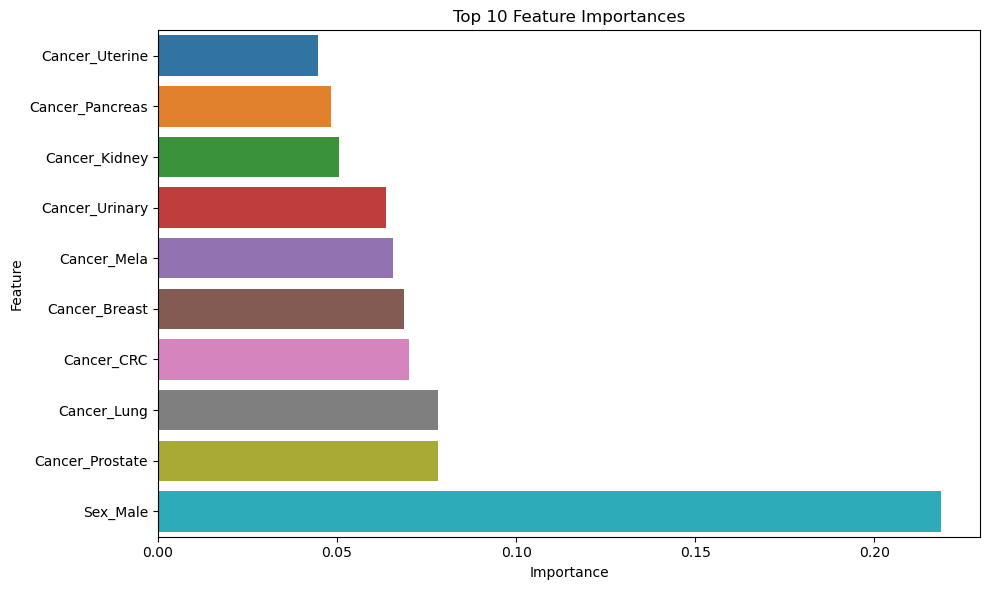

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# train a Random Forest Classifier
clf = RandomForestClassifier(random_state=50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# plot 10 most important features
importances = clf.feature_importances_
feature_names = X.columns
top_indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[top_indices], y=np.array(feature_names)[top_indices])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()